# Examining the competitiveness of the Top 5 European Football Leagues

### Overview

This notebook is divided into 5 modules :

* Scraping the Odds Data from the "footballdata.co.uk" website
* Cleaning the odds table  
* Scraping the XG Performance Data from the "Fbref.com" website
* Merging the Odds and XG table together to create a single consolidated table
* Calculating the slopes for each League

In [1]:
# Importing the packages that will be required for this analysis
import pandas as pd
import pandasql
import numpy as np
import seaborn as sns
import requests
import io
import datetime
import matplotlib.pyplot as plt
!pip install fuzzywuzzy

# Importing the relevant functions
from scipy import stats
from scipy.stats import linregress
from pandasql import sqldf
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from datetime import datetime

C:\Users\sfern\AppData\Local\Continuum\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Specify the version of the requests package, which is compatible with the websites we are dealing with
!pip install requests
!pip install requests==2.11.1 

### 1. Scraping the Odds Data from the "footballdata.co.uk" website

We will be utilizing the website Bet 365's odds data.
If there are matches that do not have the odds data from Bet 365, we will use BWin's Odds.

Both are available from the website "footballdata.co.uk".
The website has the odds information for each of the 5 leagues in separate webpages.

Moreover, they are stored in the form of csv's.

In [3]:
#First, defining the User Agent
headers = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"}

#Create a list with each of the 5 country names
country = ['england','spain','italy','germany','france']

#Initializing a dataframe 
df_1 = pd.DataFrame()

#Storing the column names that are required from these csvs in a list
colnamelist = ['Div','Date','HomeTeam','AwayTeam','B365H','B365A','BWH','BWA']

# Running a for loop to take in the links of each league one by one
for i in country :
    # Store the page of the respective league in the temporary "page" variable
    page = "https://www.football-data.co.uk/" + i + "m.php"
    
    # Send a request to the page
    res = requests.get(page,headers = headers)
    
    # Extract the contents of the page into the "soup" variable
    soup = BeautifulSoup(res.content,'html.parser')
    
    #Find all the "a" tags on the page from which we can obtain the csvs
    links = soup.find_all("a")
    
    # The names of the csv files for the 20/21 season for england,spain and italy begin in the 59th index of the links object. 
    # The names of the csv files for the 20/21 season for france and germany begin in the 60th index of the links object.
    # The names of the csv files for the previous seasons for EPL are in the order of 5 indexes successively,
    # from the 59th position onwards
    # For La Liga and Serie A, it is in the order of 2 indexes succcessively, from the 59th index
    # For Bundesliga and Ligue, they are in the order of 2 indexes successively
    
    if "england" in page :
    #Running a for loop starting from the 59th index, and iterating through the next 5 indexes in jumps of 5
        for j in range(59,75,5) :
            #Store the csv name into "a" variable
            a = links[j].get("href")
            #Use the page prefix as well as the csv name obtained above to get the complete link of the csv
            csv = "https://www.football-data.co.uk/" + a
            # Send a request to get the complete link of the csv file, and store the contents in the "csvrep" object
            csvrep = requests.get(csv).content
            # Decode the csvrep object, of bytes datatype, get file-like access to this string, and store it in a csv file
            tempcsv = pd.read_csv(io.StringIO(csvrep.decode('utf-8')),usecols = colnamelist)
            # Append it to the dataframe declared above
            df_1 = df_1.append(tempcsv)
    elif "spain" in page or "italy" in page :
        for j in range(59,66,2) :
            #Store the csv name into "a" variable
            a = links[j].get("href")
            #Use the page prefix as well as the csv name obtained above to get the complete link of the csv
            csv = "https://www.football-data.co.uk/" + a
             # Send a request to get the complete link of the csv file, and store the contents in the "csvrep" object
            csvrep = requests.get(csv).content
            # Decode the csvrep object, of bytes datatype, get file-like access to this string, and store it in a csv file
            tempcsv = pd.read_csv(io.StringIO(csvrep.decode('utf-8')),usecols = colnamelist)
            # Append it to the dataframe declared above
            df_1 = df_1.append(tempcsv)
    else :
        for j in range(60,67,2) :
            #Store the csv name into "a" variable
            a = links[j].get("href")
            #Use the page prefix as well as the csv name obtained above to get the complete link of the csv
            csv = "https://www.football-data.co.uk/" + a
             # Send a request to get the complete link of the csv file, and store the contents in the "csvrep" object
            csvrep = requests.get(csv).content
            # Decode the csvrep object, of bytes datatype, get file-like access to this string, and store it in a csv file
            tempcsv = pd.read_csv(io.StringIO(csvrep.decode('utf-8')),usecols = colnamelist)
            # Append it to the dataframe declared above
            df_1 = df_1.append(tempcsv)        

In [4]:
# Let's check out the dataframe
pd.set_option('display.max_rows',10)
df_1.head(10)

,Div,Date,HomeTeam,AwayTeam,B365H,B365A,BWH,BWA
0,E0,12/09/2020,Fulham,Arsenal,6.00,1.53,5.50,1.57
1,E0,12/09/2020,Crystal Palace,Southampton,3.10,2.37,3.00,2.45
2,E0,12/09/2020,Liverpool,Leeds,1.28,9.50,1.26,10.50
3,E0,12/09/2020,West Ham,Newcastle,2.15,3.40,2.15,3.40
4,E0,13/09/2020,West Brom,Leicester,3.80,1.95,3.70,2.00
5,E0,13/09/2020,Tottenham,Everton,1.83,4.33,1.85,4.33
6,E0,14/09/2020,Brighton,Chelsea,5.00,1.61,5.00,1.65
7,E0,14/09/2020,Sheffield United,Wolves,3.25,2.37,3.40,2.30
8,E0,19/09/2020,Everton,West Brom,1.50,6.50,1.55,6.00
9,E0,19/09/2020,Leeds,Fulham,1.61,5.75,1.62,5.50


In [5]:
# Checking to see if all the leagues are present
df_1["Div"].unique()

array(['E0', 'SP1', 'I1', 'D1', 'F1'], dtype=object)

All the leagues are populated! 

** **

### 2. Cleaning the Odds Table

Checking to see if there are any null values in the table

In [6]:
df_1.isnull().sum()

Div         0
Date        0
HomeTeam    0
AwayTeam    0
B365H       4
B365A       4
BWH         2
BWA         2
dtype: int64

In [7]:
# Looks like there are 4 null values in Bet 365's Home odds columns, and 2 in BetWins. 
# Let's view the null records in the B365H column
df_1[df_1["B365H"].isnull()]

,Div,Date,HomeTeam,AwayTeam,B365H,B365A,BWH,BWA
35,I1,18/10/2020,Udinese,Parma,NaN,NaN,1.80,4.6
37,I1,19/10/2020,Verona,Genoa,NaN,NaN,NaN,NaN
26,F1,13/09/2020,Paris SG,Marseille,NaN,NaN,1.50,5.5
66,F1,18/10/2020,Monaco,Montpellier,NaN,NaN,1.48,6.0


In [8]:
# For 3 of the 4 records above, we can utilize the odds provided by Betwin (BW). 
# For 1 record (Verona vs Genoa), since we do not have any odds data, we will eliminate the record

# Imputing Betwin's odds in those cells where Bet 365's odds have null values
df_1 = sqldf('''
                select distinct *
                from
                    (
                    select distinct Div,
                                    Date,
                                    HomeTeam,
                                    AwayTeam,
                                    case when B365H is null then BWH else B365H end as B365H,                                
                                    case when B365A is null then BWA else B365A end as B365A
                    from df_1   
                     )
                 where B365H is not null
            '''
              )

In [9]:
# Now that we have imputed the values, and removed the null records, 
#lets do a final check to see if any null values remain
df_1.isnull().sum()

Div         0
Date        0
HomeTeam    0
AwayTeam    0
B365H       0
B365A       0
dtype: int64

In [10]:
# Now, checking to see if all the values for each league are present
df_check = df_1["Div"].value_counts().sort_values(ascending = True)
df_check

D1     1224
F1     1419
I1     1519
SP1    1520
E0     1520
Name: Div, dtype: int64

### Bundesliga 

Only 18 teams compete, which results in a net total of 18*17 = 306 games in 1 season. 

**Hence across the 4 seasons, we had 306*4 = 1224 games. CHECKS OUT!** 

### Ligue 1,
Excluding the 19/20 season, we had 380 games * 3 seasons = 1140 games. 

In the 19/20 season, all teams, except PSG and Strasbourg, played 28 games, whereas these two played 27 

So, (27 gameweeks * 10 matches per gameweek) + (1 gameweek * 9 matches) = 279 games in 19/20

**Hence, in total, 1140 + 279 = 1419 games. CHECKS OUT!**

### EPL and La Liga 
**We had 380 games per season. So 380*4 = 1520. CHECKS OUT!** 

### Serie A
We had 380 * 4 = 1520 games. However, there was one record that was eliminated earlier. 

**So 1520 - 1 = 1519 games. CHECKS OUT!** 

**Looks like we have our odds for each match across the top 5 leagues for the past 4 seasons!**








** **

### 3. Scraping the XG Performance Data from the "Fbref.com" website

* We will use FBref.com's XG values, that are very accurate, as a result of using freeze frames.
* A freeze frame captures the position of all the players on the pitch while the shot is being taken.
* For example, a shot from 6 yards with the defenses packed in front of goal will have a lower XG, as compared to when the goal is open. 
* Fbref.com's XG stats account for such occurences, thus making it a reliable source

In [11]:
# First, we need to get the links of all the leagues on Fbref.com

league_page_list = ['https://fbref.com/en/comps/9/Premier-League-Stats',
                   'https://fbref.com/en/comps/13/Ligue-1-Stats',
                   'https://fbref.com/en/comps/20/Bundesliga-Stats',
                   'https://fbref.com/en/comps/11/Serie-A-Stats',
                   'https://fbref.com/en/comps/12/La-Liga-Stats']

# Let's create an empty list to store the links of the webpages that have the XG scores
finallinks = []

# Run a loop through the list above
for k in league_page_list :
    
    # Send a request to scrape the page of each league
    tree = requests.get(k,headers = headers)

    # Use BeautifulSoup to get the contents of the page
    Bsoup = BeautifulSoup(tree.content,'html.parser')

    # Now that we have entered into the league page, 
    # get the link that has the index of all the past seasons data for that league 
    l = Bsoup.find_all("li",{"class" : "index"})[0].find("a").get("href")
    
    # Append the link to the fbref.com domain name to get the complete history link for that league
    historylink = 'https://fbref.com/' + l
    
    # Now that we have the history link, lets request access to that page and get the contents
    nexttree = requests.get(historylink, headers = headers)
    Bsou = BeautifulSoup(nexttree.content,'html.parser')
    
    # Within the history page, finding the tag that has the links to each of the seasons
    m = Bsou.findAll('th', attrs = {"class" : "left"}) 
        
    # For each season, take in the link in the temp variable and request access

    for z in range(1,5) :
        temp = 'https://fbref.com/' + m[z].find("a").get("href")
        res = requests.get(temp,headers = headers)
        Bso = BeautifulSoup(res.content,'html.parser')

        # Get the link for the page containing the XG scores
        mp = Bso.find_all("li",{"class" : "full"})[1].find("a").get("href")

        # create the full url
        templink = 'https://fbref.com/' + mp

        # Store these links into a list
        finallinks.append(templink)

In [12]:
# Examining the finallinks list that has the webpages of all 5 leagues for the past 4 seasons
# Checking the length of this list as a check. It should have 20 records
finallinks

['https://fbref.com//en/comps/9/schedule/Premier-League-Scores-and-Fixtures',
 'https://fbref.com//en/comps/9/3232/schedule/2019-2020-Premier-League-Scores-and-Fixtures',
 'https://fbref.com//en/comps/9/1889/schedule/2018-2019-Premier-League-Scores-and-Fixtures',
 'https://fbref.com//en/comps/9/1631/schedule/2017-2018-Premier-League-Scores-and-Fixtures',
 'https://fbref.com//en/comps/13/schedule/Ligue-1-Scores-and-Fixtures',
 'https://fbref.com//en/comps/13/3243/schedule/2019-2020-Ligue-1-Scores-and-Fixtures',
 'https://fbref.com//en/comps/13/2104/schedule/2018-2019-Ligue-1-Scores-and-Fixtures',
 'https://fbref.com//en/comps/13/1632/schedule/2017-2018-Ligue-1-Scores-and-Fixtures',
 'https://fbref.com//en/comps/20/schedule/Bundesliga-Scores-and-Fixtures',
 'https://fbref.com//en/comps/20/3248/schedule/2019-2020-Bundesliga-Scores-and-Fixtures',
 'https://fbref.com//en/comps/20/2109/schedule/2018-2019-Bundesliga-Scores-and-Fixtures',
 'https://fbref.com//en/comps/20/1634/schedule/2017-201

In [13]:
# Now that we have the links for each League in each of the past 4 seasons, we have to parse through the list,
# and pick up the XG scores, along with the teamnames, and the dates

# Lets create five lists, to take in the values from the webpage for these variables
hometeam_list = []
awayteam_list = []
homexg_list = []
awayxg_list = []
date_list = []

# For each link, the tags that contain the relevant information have different starting and ending positions, 
# as well as occur at different frequencies

# Hence, we need to initialize a dataframe that takes in all of these positions for each link and extract the values

# Creating a dictionary to store the positions of the HOME team names in each of the 20 links 
hometeam_df =  pd.DataFrame({"start" : [1,1,1,1,2,1,2,2,2,2,2,2,1,1,1,1,1,1,1,1],
              "end" : [2500,2500,2500,2500,2550,1545,2576,2534,2058,2046,2040,2040,2250,2250,2250,2250,2250,2250,2250,2250],
              "counter" : [5,5,5,5,6,5,6,6,6,6,6,6,5,5,5,5,5,5,5,5]})

# Creating a dictionary to store the positions of the AWAY team names in each of the 20 links
awayteam_df = pd.DataFrame({"start" : [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2],
                "end" : [3085,3085,3085,3085,2970,2169,3005,2950,2401,2394,2380,2380,3085,3085,3085,3085,3085,3085,3085,3085],
                "counter" : [7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7]})

# Creating a dictionary that stores the dates on which the match is played
# The match dates are important because it will be part of the primary key on which the join with the odds table will take
# place

date_df = pd.DataFrame({"start" : [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
            "end" : [3084,3084,3084,3084,2972,2165,3000,2951,2407,2393,2379,2379,3084,3084,3084,3084,3084,3084,3084,3084],
            "counter" : [7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7]})

# # Hometeam name, homexg and awayxg values all lie within the same class
# # The homexg values are + 1 positions ahead of the respective home team name positions in the tags.
# # For the awayxg values, they are + 2 positions ahead
# # Hence, we need to add + 1 and + 2 to the "start" and "end" columns in the hometeam_df to get the dataframe for the homexg and awayxg values

# First, create 2 copies of the hometeam_df dataframe
homexg_df = hometeam_df.copy()
awayxg_df = hometeam_df.copy()

# #Next, add + 1 to the start and end columns for the homexg values
homexg_df["start"] = homexg_df["start"] + 1
homexg_df["end"] = homexg_df["end"] + 1

# Next add + 2 to the start and end columns for the awayxg values
awayxg_df["start"] = awayxg_df["start"] + 2
awayxg_df["end"] = awayxg_df["end"] + 2


In [14]:
# Creating a function that will extract the texts within these positions and store the values in a list

def loop(input_dataframe,output_list) :

    #Run through the finallinks list one by one, and get access to the page 
    for xg in range(len(finallinks)) :
        req = requests.get(finallinks[xg],headers = headers)
        Bs = BeautifulSoup(req.content,'html.parser')

        # Run through the input dataframe, that contains the start,end and counter values for each link, for that variable
        for ht in range(input_dataframe["start"][xg],input_dataframe["end"][xg],input_dataframe["counter"][xg]) :
            try :
                if Bs.find_all("td",{"class" : "right"})[ht].text != '' :
                    output_list.append(Bs.find_all("td",{"class" : "right"})[ht].text)
            except IndexError :
                break    
                
# Creating a function for getting the awayteam name values from each link

def loop_second(input_dataframe,output_list) :

    #Run through the finallinks list one by one, and get access to the page 
    for xg in range(len(finallinks)) :
        req = requests.get(finallinks[xg],headers = headers)
        Bs = BeautifulSoup(req.content,'html.parser')

        # Run through the input dataframe, that contains the start,end and counter values for each link, for that variable
        for ht in range(input_dataframe["start"][xg],input_dataframe["end"][xg],input_dataframe["counter"][xg]) :
            try :
                if Bs.find_all("td",{"class" : "left"})[ht].text != '' :
                    output_list.append(Bs.find_all("td",{"class" : "left"})[ht].text)
            except IndexError :
                break    

In [ ]:
# Now that the functions have been defined, lets run them to obtain the respective values for each variable 
loop(hometeam_df,hometeam_list)
loop(homexg_df,homexg_list)
loop(awayxg_df,awayxg_list)
loop_second(awayteam_df,awayteam_list)
loop_second(date_df,date_list)

In [ ]:
# # Storing the lists in a dataframe
df_2 = pd.DataFrame({"Date" : date_list,
                    "Home_Team" : hometeam_list,
                    "Home_XG" : homexg_list,
                    "Away_Team" : awayteam_list,
                    "Away_XG" : awayxg_list})                

In [16]:
# Lets view the dataframe
df_2.head()

,Date,Home_Team,Home_XG,Away_Team,Away_XG
0,12-09-2020,Fulham,0.2,Arsenal,1.8
1,12-09-2020,Crystal Palace,0.7,Southampton,0.8
2,12-09-2020,Liverpool,3.3,Leeds United,0.6
3,12-09-2020,West Ham,1.1,Newcastle Utd,1.5
4,13-09-2020,West Brom,0.5,Leicester City,2.2


In [17]:
# Checking to see if there are any null values in this dataframe
df_2.isnull().sum()

Date         0
Home_Team    0
Home_XG      0
Away_Team    0
Away_XG      0
dtype: int64

**No null values! We are good to go with the XG table!**

### 4.Merging the Odds and XG table together to create a single consolidated table

Now that we have both our odds and XG tables, we can join them to create a single consolidated table

However, first, checking to see if the teamnames in both the tables are exactly the same.

It is highly likely that there are slight differences e.g. Man United and Manchester United in both the tables

In [18]:
# To do this, we will first get the unique team names in both the tables
unique_home_teams_df1 = pd.DataFrame(df_1["HomeTeam"].unique())
unique_home_teams_df2 = pd.DataFrame(df_2["Home_Team"].unique())

# Print the number of unique teams in both the tables
print("The number of unique teams in both tables are {} in df_1 and {} in df_2".format(len(unique_home_teams_df1),len(unique_home_teams_df2)))

The number of unique teams in both tables are 129 in df_1 and 129 in df_2


In [19]:
# Next, lets inner join the two tables to get the list of teams having the same names in both the tables
join_check = pd.merge(unique_home_teams_df1,unique_home_teams_df2,how = "inner")

# Print the length of the above table 
print("The number of teams that are common in both the tables are {}".format(len(join_check)))

The number of teams that are common in both the tables are 92


Looks like 92 teams have similar names.

However, (129-92) = 37 teams have different names in both the tables

Let's get the names of these 37 teams from both the df_tables

In [42]:
# Append the unique team names from both the tables
total_teams = pd.DataFrame(unique_home_teams_df1.append(unique_home_teams_df2))

#Rename the header of the column 
total_teams.columns = ['Team']

# Drop the duplicate values. This will only keep the teams having different names in both the tables
total_teams.drop_duplicates(subset = "Team",keep = False,inplace = True)

#Reset the index of this table
total_teams.reset_index(inplace = True,drop = True)

# Viewing the total teams dataframe
display(total_teams.head())

,Team
0,Sheffield United
1,Leeds
2,Man United
3,Newcastle
4,Leicester


In [21]:
# This table has all the teams having different names in both the tables
# Examining the table, it looks like for most team names, the successive cell contains the alternate team name
# Writing a query to create a column that takes in the suceeding value for each row

temp_teams = sqldf('''select Team, 
                             case when Next_team is null then lag(team) over () else Next_team end as Lead
                      from                         
                          (
                          select *,lead(Team) over() as Next_team 
                          from 
                              (
                              select *
                              from total_teams order by 1
                              )
                          )
                '''
                  )

In [22]:
# Using a matching function that checks if the values in adjacent cells in the same row are an approximate match or no
# Using the fuzzywuzzy module to perform this operation

# Declare an empty variable that stores the highest similarity rating between two text strings
highest_value = None

#Declare an empty variable that takes in the name of the team having the highest match value
matched_name = None
next_value = None

# Declare an empty variable that holds the similarity rating of the latest iteration
test_var = None

# Declaring a list that stores the final matched name for each team
final_matched_name = []

#Loop through the team list
for j in range(len(temp_teams)) :    
    #Calculate the match score between the jth element and the 1st element in the df (i.e. Alaves) as the initial value
    highest_value = fuzz.ratio(temp_teams["Team"][j],temp_teams["Lead"][0])
    # Store the 1st element name in the df as the initial value
    matched_name = temp_teams["Lead"][0]
    # Now run another loop through the list
    for k in range(1,74) :
        # Calculate the match value between the item in the jth position of the Team column, and the kth position of the 
        # Lead column
        next_value = fuzz.ratio(temp_teams["Team"][j],temp_teams["Lead"][k])
        # If the match value of the next iteration is higher than the highest match value;
        if next_value > highest_value and next_value != 100:
            #Replace the highest value with the next value
            highest_value = next_value
            # Replace the value in the matched name variable with the team name of the iteration with the highest match value
            matched_name = temp_teams["Lead"][k]
        elif highest_value > next_value and highest_value != 100 :
            pass
        else :
            pass
            
    final_matched_name.append(matched_name)

In [23]:
# Converting the final list into a dataframe
final_matched_name = pd.DataFrame(final_matched_name)

#Renaming the column of this dataframe
final_matched_name.columns = ["Matched_name"]

# Concatenating the matched teanmame list with the original dataframe for examination
matched_df = pd.concat([temp_teams["Team"],final_matched_name],axis = 1)

#Viewing the dataframe
matched_df.head()

,Team,Matched_name
0,Alaves,Alavés
1,Alavés,Alavés
2,Arminia,Verona
3,Ath Bilbao,Athletic Club
4,Ath Madrid,Atlético Madrid


In [24]:
# Looks like there are a few teams still having incorrect names, even after matching
# Manually coercing them to the right names

final_names = sqldf(
                        '''select distinct Team,
                                       case when Team = "Arminia" and Matched_name = "Verona" then "Bielefeld" 
                                            when Team = "Athletic Club" and Matched_name = "Atlético Madrid" then "Ath Bilbao" 
                                            when Team = "Bielefeld" and Matched_name = "Leeds" then "Arminia" 
                                            when Team = "Leeds" and Matched_name = "Leganes" then "Leeds United" 
                                            when Team = "Leeds United" and Matched_name = "Sheffield United" then "Leeds"
                                            when Team = "Man United" and Matched_name = "Man City" then "Manchester Utd" 
                                            when Team = "Manchester City" and Matched_name = "Manchester Utd" then "Man City"
                                            when Team = "Manchester Utd" and Matched_name = "Manchester City" then "Man United"
                                            when Team = "Spal" and Matched_name = "Espanol" then "SPAL" 
                                            when Team = "Alavés" then "Alaves"
                                            else Matched_name end as Matched_name 
                        from matched_df 
                        group by 1,2
                        order by 1,2
                        '''
                   )

In [25]:
# Lets view the final matched table
pd.set_option('display.max_rows',None)
final_names

,Team,Matched_name
0,Alaves,Alavés
1,Alavés,Alaves
2,Arminia,Bielefeld
3,Ath Bilbao,Athletic Club
4,Ath Madrid,Atlético Madrid
5,Athletic Club,Ath Bilbao
6,Atlético Madrid,Ath Madrid
7,Bielefeld,Arminia
8,Cadiz,Cádiz
9,Cardiff,Cardiff City


Looks like we have our matched names!

In [26]:
# Finally, we will replace the names of the teams in the XG table(df_2) that are different than the ones from the odds table (df_1),
# by utilizing this matched table

# If the name in the "Team" column of the final_names table matches the Home and Away team name in the XG table (df_2),
# we will replace the Home and Away team name of the XG table with the Matched_name column from the final_names table

df_2_matched = sqldf(''' select distinct Date,
                                         case when Home_match is not null then Home_match else Home_Team end as HomeTeam,
                                         Home_XG,
                                         case when Away_match is not null then Away_match else Away_Team end as AwayTeam,
                                         Away_XG
                         from
                         (
                             select distinct a.*,
                                             b.Home_match,
                                             c.Away_match
                             from df_2 a
                             left join
                             (
                             select distinct Team,
                                             Matched_name as Home_match
                             from final_names 
                             ) b
                             on a.Home_Team = b.Team  
                             left join
                             (
                             select distinct Team,Matched_name as Away_match
                             from final_names 
                             ) c
                             on a.Away_Team = c.Team                           
                          )   
                             '''
                     )

In [27]:
pd.set_option("display.max_rows",None)
# Lets view the final odds table with the new names
df_2_matched.head(5)

,Date,HomeTeam,Home_XG,AwayTeam,Away_XG
0,12-09-2020,Fulham,0.2,Arsenal,1.8
1,12-09-2020,Crystal Palace,0.7,Southampton,0.8
2,12-09-2020,Liverpool,3.3,Leeds,0.6
3,12-09-2020,West Ham,1.1,Newcastle,1.5
4,13-09-2020,West Brom,0.5,Leicester,2.2


Finally, to join our Odds table (df_1) with our new XG table (df_2_matched), to get a single consolidated dataframe,

we would need the Date, HomeTeam name & AwayTeam as the keys. 

However, the date columns in both the tables are in slighly different formats.

In [28]:
# Changing the datatype of the Date column in both the tables to be the "datetime" datetype

df_1['Date'] = pd.to_datetime(df_1['Date'])
df_2_matched["Date"] = pd.to_datetime(df_2_matched["Date"])

# #Checking the datatypes of the date columns in these two dataframes
print(df_1["Date"].dtypes,df_2_matched["Date"].dtypes)

datetime64[ns] datetime64[ns]


Further, checking to see in each dataframe, how many records are contained in each calendar year

In [29]:
# Extracting the year from the Date column in both the dataframes
df_1['Year'] = pd.DatetimeIndex(df_1['Date']).year
df_2_matched['Year'] = pd.DatetimeIndex(df_2_matched['Date']).year

# Checking for each calendar year, whether or not we have the same number of records in each dataframe
print(df_1["Year"].value_counts())
print(df_2_matched["Year"].value_counts())

2019    1823
2018    1808
2020    1569
2021    1093
2017     909
Name: Year, dtype: int64
2019    1823
2018    1808
2020    1570
2021    1093
2017     909
Name: Year, dtype: int64


Except for 2020, all years have a perfect match!

We have an additional record in the df_2 dataframe for 2020, which we will eliminate as we do not have the odds for that record.

In [30]:
# Since both the Date columns have now been formatted correctly, in addition to our Home and Away Team name columns, we will 
# now merge both the dataframes together to create a single dataset. 

# In doing so, the extra record will get eliminated!

final_df = sqldf('''select distinct  a.Div,
                                     a.Date,
                                     a.HomeTeam,
                                     Home_XG,
                                     B365H as Home_odds,
                                     a.AwayTeam,
                                     Away_XG,
                                     B365A as Away_odds
                     from df_1 a
                     left join df_2_matched b
                     using (Date,HomeTeam,AwayTeam)
                     '''
                   )

In [31]:
# Lets view the dataframe
final_df.head(5)

,Div,Date,HomeTeam,Home_XG,Home_odds,AwayTeam,Away_XG,Away_odds
0,E0,2020-12-09 00:00:00.000000,Fulham,0.2,6.00,Arsenal,1.8,1.53
1,E0,2020-12-09 00:00:00.000000,Crystal Palace,0.7,3.10,Southampton,0.8,2.37
2,E0,2020-12-09 00:00:00.000000,Liverpool,3.3,1.28,Leeds,0.6,9.50
3,E0,2020-12-09 00:00:00.000000,West Ham,1.1,2.15,Newcastle,1.5,3.40
4,E0,2020-09-13 00:00:00.000000,West Brom,0.5,3.80,Leicester,2.2,1.95


In [32]:
# Lets check to see if there are any null values in any of the columns
final_df.isnull().sum()

Div          0
Date         0
HomeTeam     0
Home_XG      0
Home_odds    0
AwayTeam     0
Away_XG      0
Away_odds    0
dtype: int64

**Now that we have our consolidated dataframe, lets get to the analysis!**

### 5. Calculating the slopes for each League

We wanted to understand that for different ranges of odds differentials (gap in odds between favorite and underdog) 
in a league across the past 4 seasons, how much does their in-game performance differ by, based on their XG values

We will first plot these two metrics together, for each League separately :

**On the X-Axis, we have the difference in win %'s (gap in odds differentials) between the underdog and superior**

**On the Y-Axis, we have the difference in XG values between the underdog and superior**

We would then calculate the slope of the graph, for each League.

**The League with the lowest slope is the League which is the most competitive, since for a unit increase in win %, the relative difference in XG generated is also the least.** 

In [33]:
# First, lets convert the odds values into probabilities.
# Since these are fractional odds, we will take the reciprocal of the odds to get the win probabilities

final_df["Home_prob"] = 1/final_df["Home_odds"]
final_df["Away_prob"] = 1/final_df["Away_odds"]

In [34]:
# Next, calculate the absolute difference in the win probabilities between the two teams in each record, 
# and represent it as a percentage
final_df["Odds_diff"] = abs(final_df["Home_prob"] - final_df["Away_prob"])*100
final_df.head()

,Div,Date,HomeTeam,Home_XG,Home_odds,AwayTeam,Away_XG,Away_odds,Home_prob,Away_prob,Odds_diff
0,E0,2020-12-09 00:00:00.000000,Fulham,0.2,6.00,Arsenal,1.8,1.53,0.166667,0.653595,48.692810
1,E0,2020-12-09 00:00:00.000000,Crystal Palace,0.7,3.10,Southampton,0.8,2.37,0.322581,0.421941,9.936028
2,E0,2020-12-09 00:00:00.000000,Liverpool,3.3,1.28,Leeds,0.6,9.50,0.781250,0.105263,67.598684
3,E0,2020-12-09 00:00:00.000000,West Ham,1.1,2.15,Newcastle,1.5,3.40,0.465116,0.294118,17.099863
4,E0,2020-09-13 00:00:00.000000,West Brom,0.5,3.80,Leicester,2.2,1.95,0.263158,0.512821,24.966262


In [35]:
# Next, lets calculate the difference in XG between the superior and underdog teams
final_df["XG_diff"] = np.where(final_df["Home_prob"] > final_df["Away_prob"],final_df["Home_XG"] - final_df["Away_XG"],final_df["Away_XG"] - final_df["Home_XG"])
final_df.head()

,Div,Date,HomeTeam,Home_XG,Home_odds,AwayTeam,Away_XG,Away_odds,Home_prob,Away_prob,Odds_diff,XG_diff
0,E0,2020-12-09 00:00:00.000000,Fulham,0.2,6.00,Arsenal,1.8,1.53,0.166667,0.653595,48.692810,1.6
1,E0,2020-12-09 00:00:00.000000,Crystal Palace,0.7,3.10,Southampton,0.8,2.37,0.322581,0.421941,9.936028,0.1
2,E0,2020-12-09 00:00:00.000000,Liverpool,3.3,1.28,Leeds,0.6,9.50,0.781250,0.105263,67.598684,2.7
3,E0,2020-12-09 00:00:00.000000,West Ham,1.1,2.15,Newcastle,1.5,3.40,0.465116,0.294118,17.099863,-0.4
4,E0,2020-09-13 00:00:00.000000,West Brom,0.5,3.80,Leicester,2.2,1.95,0.263158,0.512821,24.966262,1.7


In [36]:
# Renaming the league names in the final_df table
final_df["Div"].replace({"E0" : "EPL", "SP1" : "La Liga","I1" : "Serie A" , "D1" : "Bundesliga" , "F1" : "Ligue 1"},inplace = True)
final_df["Div"].unique()

array(['EPL', 'La Liga', 'Serie A', 'Bundesliga', 'Ligue 1'], dtype=object)

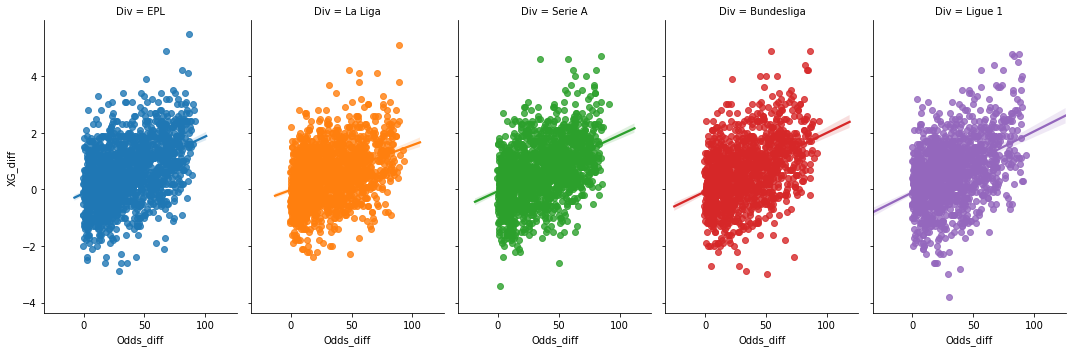

In [37]:
# Now, for each league, lets visualize the two metrics
# We are going to visualize these two metrics on a scatter plot, for each league, with a regression line

fig,ax = plt.subplots()
fig.set_size_inches(8,20)
%matplotlib inline
ax = sns.lmplot(x="Odds_diff",y="XG_diff",data = final_df,hue = "Div",col = "Div",height=5, aspect=0.6, x_jitter=1,fit_reg=True)

**Findings from the graphs above :**

* Just examining the graphs visually, it looks like the **Spanish League** seems to have the lowest slope among all Leagues
* Each league looks to have an increasing positive trend as expected i.e as the Gap in odds increases between the superior and underdog team, the relative difference in XG also increases


In [38]:
# Creating a function that 
# 1) takes in the records for a particular league 
# 2) Calculates the correlation coefficient between the two metrics for that league
# 3) Calculates the slope between the two metrics, and stores it into a dataframe

def comp_test() :
    #Create 4 empty lists to store the necessary information
    leagues = []
    slope = []
    corr = []
    pvalue = []
    
    # Get the unique league names  
    unique_leagues = final_df["Div"].unique()
    
    for i in unique_leagues :        
        df_temp = final_df[final_df["Div"] == i]
        leagues.append(i)
        
        #Calculating the slope, correlation and p-value of the Odds and xG differences columns
        corr.append(df_temp["Odds_diff"].corr(df_temp["XG_diff"]))
        slope.append(stats.linregress(df_temp["Odds_diff"],df_temp["XG_diff"])[0])
        pvalue.append(stats.linregress(df_temp["Odds_diff"],df_temp["XG_diff"])[3])
    
    # Initializing a variable by the name metrics, that is global in nature 
    global metrics
    
    #Store the statistical values in the metrics dataframe
    metrics= pd.DataFrame({"league" : leagues, 
                            "corr" : corr,
                            "slope" : slope,
                            "pvalue" : pvalue})

# Running the function
comp_test()    

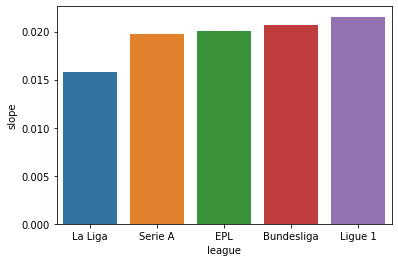

In [39]:
# Now that the slope has been calculated. lets visualize it for each league
ax = sns.barplot(x = "league", y = "slope", data = metrics, order = metrics.sort_values("slope").league) 

In [40]:
# Lets also check the p-values for the respective slopes
metrics[["league","pvalue"]]

,league,pvalue
0,EPL,3.388839e-75
1,La Liga,4.870210e-49
2,Serie A,3.726994e-70
3,Bundesliga,1.035118e-53
4,Ligue 1,5.031336e-65


Looks like the p-values are statistically significant!